Instruction to use:

See this walktrhough video: https://youtu.be/uXJdhP3vyYk 

In [21]:
# import os

# paths_dic={
#     "directory_of_images": r"C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test",
# }

# desired_N_of_runs = 5


# defineDic_tool={
#     "tool_name": "Polyp_detection", # only words, numbers and underline (_)
#     "tool_description": "Chose one of the mentioned options to tell if any polyp exist in this image.",
#     "tool_options":
#         [
#             "Polyp visible",
#             "Polyp not visible"
#     ]
# }



# #--------------- don't need change
# parallel_run_N = 3
# paths_dic["empty_excel_path"] = os.path.join(paths_dic["directory_of_images"], "emptyDesign.xlsx")
# paths_dic["answered_excel_path"] = os.path.join(paths_dic["directory_of_images"], "answered.xlsx")
# paths_dic["mask_importance"] = os.path.join(paths_dic["directory_of_images"], "mask_importance.xlsx")
# paths_dic["mask_importance_wConNorm"] = os.path.join(paths_dic["directory_of_images"], "mask_importance_wConNorm.xlsx")



## Create masked image

### Function for masking

In [22]:
import os
from PIL import Image, ImageFilter

def mask_tile(image, x, y, tile_width, tile_height):
    """ Mask a specific tile in the image. """
    masked_image = image.copy()
    draw = Image.new('RGBA', image.size, (0, 0, 0, 0))
    mask = Image.new('L', (tile_width, tile_height), 0)
    draw.paste(mask, (x, y))
    masked_image.paste(draw, mask=draw)
    return masked_image

def blur_tile(image, x, y, tile_width, tile_height, blur_radius=20):
    """ Blur a specific tile in the image. """
    blurred_image = image.copy()
    # Extract the tile
    tile = blurred_image.crop((x, y, x + tile_width, y + tile_height))
    # Apply Gaussian blur to the tile
    blurred_tile = tile.filter(ImageFilter.GaussianBlur(radius=blur_radius))
    # Paste the blurred tile back into the image
    blurred_image.paste(blurred_tile, (x, y))
    return blurred_image

def process_images(folder_path, num_rows, num_cols, blur_or_mask="mask", sliding=False):
    images = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    file_name_list = []
    for image_name in images:
        image_path = os.path.join(folder_path, image_name)
        image = Image.open(image_path)
        width, height = image.size

        # Calculate tile dimensions (same for both static and sliding)
        tile_width = width // num_cols
        tile_height = height // num_rows

        # Create directory for processed images
        output_dir = os.path.join(folder_path, f"{os.path.splitext(image_name)[0]}_{blur_or_mask}_{num_rows}x{num_cols}_{'sliding' if sliding else 'static'}")
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        if sliding:
            # Generate positions for the sliding window
            x_positions = range(0, width - tile_width + 1, tile_width // 2)
            print(x_positions)
            y_positions = range(0, height - tile_height + 1, tile_height // 2)
            positions = [(x, y) for y in y_positions for x in x_positions]
        else:
            # Generate positions for the static grid
            positions = [(col * tile_width, row * tile_height) 
                         for row in range(num_rows) 
                         for col in range(num_cols)]

        for idx, (x, y) in enumerate(positions):
            if blur_or_mask == "mask":
                processed_image = mask_tile(image, x, y, tile_width, tile_height)
            elif blur_or_mask == "blur":
                processed_image = blur_tile(image, x, y, tile_width, tile_height)
            else:
                raise ValueError("The blur_or_mask is not correctly defined.")
            
            output_image_name = f'{idx}_{x}.{x+tile_width}_{y}.{y+tile_height}_{os.path.basename(image_name)}'
            file_name = os.path.join(output_dir, output_image_name)
            processed_image.save(file_name)
            file_name_list.append(output_image_name)

    return file_name_list


### 2x2 sliding mask (big sliding)

In [23]:
# # # Example usage:
# folder_path = paths_dic["directory_of_images"]
# num_rows = 2
# num_cols = 2
# blur_or_mask = "mask" # Set to "mask" or "blur"
# sliding = True  # Set to True for sliding window, False for static grid
# file_name_list = process_images(folder_path, num_rows, num_cols, blur_or_mask=blur_or_mask, sliding=sliding)
# print(file_name_list)

### 3x3 static (small static)

In [24]:
# # Example usage:
# folder_path = r'C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test'
# num_rows = 3
# num_cols = 3
# blur_or_mask = "blur" # Set to "mask" or "blur"
# sliding = False  # Set to True for sliding window, False for static grid
# file_name_list = process_images(folder_path, num_rows, num_cols, blur_or_mask=blur_or_mask, sliding=sliding)
# print(file_name_list)

### Other masks
You can use image editors to create manual masks (for adversial attack) with masks covering the ground truth. When you are done, you can proceed with the code (it will handle the rest). Make sure that you start the folder name with the name of original image + underline + whatever you want. 

Here are some examples.
https://link.springer.com/article/10.1007/s10044-021-01055-y 


# Create an emptyDesign excel

In [25]:
import os
import pandas as pd
import re
import subprocess
import platform
import tkinter as tk
from tkinter import messagebox


def open_excel_file(file_path):
    try:
        system = platform.system()
        if system == 'Windows':
            os.startfile(file_path)  # Windows-specific command
        elif system == 'Darwin':  # macOS
            subprocess.run(['open', file_path])
        elif system == 'Linux':
            subprocess.run(['xdg-open', file_path])
        else:
            print(f"Unsupported OS: {system}")
    except Exception as e:
        print(f"Error opening the file: {e}")

def show_popup_message(message):
    # Initialize the Tkinter window (it won't be shown)
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    # Ensure the message box appears on top of other windows
    root.attributes('-topmost', True)
    
    # Show the pop-up message box
    messagebox.showinfo("Information", message)

    # Destroy the Tkinter window after the message box is closed
    root.destroy()

  
            
def create_empty_excel(directory_path, output_excel_path, N_of_runs):
    # Regex pattern to match the filename format
    pattern = r'^(\d+)_(\d+)\.(\d+)_(\d+)\.(\d+)_(.+)$'

    # Walk through all subdirectories to find JPG files
    image_files = []
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith('.jpg'):
                image_files.append(os.path.join(root, file))

    data = []

    # Loop through each image path and create entries for each run
    for image_path in image_files:
        filename = os.path.basename(image_path)
        match = re.match(pattern, filename)
        
        if match:
            idx, x1, x2, y1, y2, original_filename = match.groups()
        else:
            idx, x1, x2, y1, y2, original_filename = "", "", "", "", "", filename

        for run in range(1, N_of_runs + 1):
            data.append({
                'image_path': image_path,
                'run_N': run,
                'image_idx': idx,
                'image_X1coordinate': x1,
                'image_X2coordinate': x2,
                'image_Y1coordinate': y1,
                'image_Y2coordinate': y2,
                'original_filename': original_filename,
                'design_model': "gpt-4o",
                'design_prompt': "",
                'design_tempreature': 1,
                'design_max_completion_token': 300,
                'design_seed' : "",
                'answer_status': "",
                'answer_rawResponse': "",
                'answer_completiontokens': "",
                'answer_prompttokens': "", 
                'answer_clean': "",
                'correctness': ""
            })

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Save the DataFrame to an Excel file
    df.to_excel(output_excel_path, index=False)
    
    print(f"Excel file created successfully: {output_excel_path}")
    print(f"Total images processed: {len(image_files)}")
    
    open_excel_file(output_excel_path)

    show_popup_message("Excel file created successfully!\nNow you should modify this file and define your model, and model parameteres.\n\nRemmeber that for each group of runs, you should define similiar model parameters. We will do N exactly similar runs to find the probabilities of each masked image, and use it for finding which masks are the most important ones. And by most important, we considered the most prevalent answer on the un-masked image (original), in N runs, as the base answer (and not the correct answer). If by masking an area, the answer changes, we would consider that this masked region is the most important region for the predicted class.")  
    
# Example usage
# directory_path = paths_dic["directory_of_images"]
# output_excel_path = paths_dic["empty_excel_path"]
# N_of_runs = desired_N_of_runs
 
# create_empty_excel(directory_path, output_excel_path, N_of_runs)

# Generate the output

## OpenAI

#### functions

In [26]:
from openai import AsyncOpenAI
import base64
import os
import pandas as pd
import asyncio
import aiohttp
import json


# Function to encode the image as base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')
    
def set_system_message(sysmsg):
    if sysmsg:
        return [{
            "role": "system",
            "content": sysmsg
        }]
    else:
        return []


def set_promptImage_message(prompt, image_path):

    image_base64 = encode_image(image_path)
    
    promptImage_message = [
        {"role": "user",
         "content": [
             {
                "type": "text",
                "text": prompt
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{image_base64}"                     
            },
            }
            ]}
        ]
    
    return promptImage_message    

def set_tool(defineDic_tool):
    my_tools = [
        {
            "type": "function",
            "function": {
                "name": defineDic_tool["tool_name"],
                "description": defineDic_tool["tool_description"],
                "parameters": {
                    "type": "object",
                    "properties": {
                        "assessment": {
                            "type": "string",
                            "enum": defineDic_tool["tool_options"]
                        }
                    },
                    "required": ["assessment"],
                }
            }
        }
    ]
    
    return my_tools


def extract_values_of_response(VLM_response):
    try:
        # Attempt to extract the "assessment" value
        tool_call = VLM_response.choices[0].message.tool_calls[0]
        arguments = tool_call.function.arguments
        parsed_arguments = json.loads(arguments)
        assessment_value = parsed_arguments.get('assessment', 'Assessment not found')
    except (AttributeError, IndexError, json.JSONDecodeError) as e:
        assessment_value = f"Error extracting assessment: {e}"

    try:
        # Attempt to extract the completion_tokens
        completion_tokens = VLM_response.usage.completion_tokens
    except AttributeError as e:
        completion_tokens = f"Error extracting completion tokens: {e}"

    try:
        # Attempt to extract the prompt_tokens
        prompt_tokens = VLM_response.usage.prompt_tokens
    except AttributeError as e:
        prompt_tokens = f"Error extracting prompt tokens: {e}"

    # Return the results
    return {
        "assessment": assessment_value,
        "completion_tokens": completion_tokens,
        "prompt_tokens": prompt_tokens
    }


#### main

In [27]:
async def asyncVLM_answer_wTools(idx, image_path, client, defineDic_tool, defineDic_modelParam, system_prompt=None):
    sysmsg =set_system_message(system_prompt)
    promptImage_message=set_promptImage_message(defineDic_modelParam['prompt'], image_path)
    my_messages=sysmsg+promptImage_message
    
    my_tools= set_tool(defineDic_tool)
    mytool_to_force={"type": "function", "function": {"name": defineDic_tool["tool_name"]}} 

    try:
        VLM_response = await client.chat.completions.create(
            messages=my_messages,
            model=defineDic_modelParam["model"],
            temperature=defineDic_modelParam["tempreature"],
            max_completion_tokens=defineDic_modelParam["max_completion_token"], 
            seed = defineDic_modelParam["seed"] if isinstance(defineDic_modelParam["seed"],int) else None,
            timeout=120,
            tool_choice= mytool_to_force,
            tools=my_tools,     
        )
        
        extract_response = extract_values_of_response(VLM_response)
        clean_class, completion_tokens, prompt_tokens  = extract_response["assessment"], extract_response["completion_tokens"],extract_response["prompt_tokens"]
    
        status = "answerGenerated"
        print(f'at index {idx}, clean_class is: {clean_class}')
    except Exception as e:
        status = f"answerFailed: {e}"
        VLM_response=clean_class=completion_tokens=prompt_tokens =None
        print(f'ERRor at index {idx}:\n{e}')
    finally:
        return idx, status, VLM_response, clean_class, completion_tokens, prompt_tokens 

#### unit test

In [28]:
# defineDic_tool={
#     "tool_name": "Polyp_detection", # only words, numbers and underline (_)
#     "tool_description": "Chose one of the mentioned options to tell if any polyp exist in this image.",
#     "tool_options":
#         [
#             "Polyp visible",
#             "Polyp not visible"
#     ]
# }

# defineDic_modelParam= {
#     "model":"gpt-4o",
#     'prompt': "This is a colonoscopy image. You are tasked with classifying the image for visibility of polyp.",
#     "tempreature":1,
#     "max_completion_token":300,
#     "seed":None,
# }




# #----test----------
# idx=1
# image_path=r"C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test\336271.jpg"
# client = AsyncOpenAI(api_key = os.getenv("OPENAI_API_KEY"))
# defineDic_tool=defineDic_tool
# defineDic_modelParam=defineDic_modelParam


# idx, status, VLM_response, clean_class, completion_tokens, prompt_tokens  = await asyncVLM_answer_wTools(idx, image_path, client, defineDic_tool, defineDic_modelParam)

# print(idx, status, VLM_response, clean_class, completion_tokens, prompt_tokens, sep="\n")

## Excel handler

#### function

In [29]:
import os
import tkinter as tk
from tkinter import messagebox
import pandas as pd

def ask_overwrite_or_continue():
    """Ask the user if they want to continue with the answered Excel or overwrite it."""
    # Create a hidden Tkinter window
    root = tk.Tk()
    root.withdraw()
    
    # Bring the window to the front
    root.attributes('-topmost', True)

    # Ask the user to continue or overwrite the file
    result = messagebox.askyesno(
        title="Continue or Overwrite",
        message=("Do you want to continue with the previously saved answered file?"
                 "\n\nYes: Continue with the answered file.\nNo: Overwrite and use the new design.")
    )
    
    # Close the Tkinter window
    root.destroy()
    
    return result

def handle_excel_file_choice(paths_dic):
    """Handles the decision of using the existing answered Excel file or a new design."""
    if os.path.exists(paths_dic["answered_excel_path"]):
        # Ask the user if they want to continue with the previous file
        user_choice = ask_overwrite_or_continue()
        
        if user_choice:  # User chose to continue with the answered file
            df = pd.read_excel(paths_dic["answered_excel_path"])
            print("Continuing with the previously answered Excel file.")
        else:  # User chose to overwrite and use the empty Excel
            df = pd.read_excel(paths_dic["empty_excel_path"])
            print("Overwriting with the new design Excel file.")
    else:
        # If the answered Excel doesn't exist, use the empty one
        df = pd.read_excel(paths_dic["empty_excel_path"])
        print("No previous answered file found, using the new design Excel file.")
    
    return df

In [30]:
async def handler_asyncVLM_answer_wTools(paths_dic,defineDic_tool, parallel_run_N):
    df = handle_excel_file_choice(paths_dic)
    last_index = df.index[-1]
    
    client = AsyncOpenAI(api_key = os.getenv("OPENAI_API_KEY"))
    i=0
    asyncio_tasks=[]
    for index, row in df.iterrows():
        try:
            if row['answer_status'] != "answerGenerated":
                defineDic_modelParam = {
                    "model": row["design_model"], 
                    'prompt': row["design_prompt"], 
                    "tempreature": row["design_tempreature"], 
                    "max_completion_token": row["design_max_completion_token"], 
                    "seed": row["design_seed"],
                }   
                asyncio_tasks.append(
                    asyncVLM_answer_wTools(index, row["image_path"],client, defineDic_tool, defineDic_modelParam)
                )
                i += 1
                # create tasks
                if (i<parallel_run_N) or (index == last_index and len(asyncio_tasks)>0):
                    results = await asyncio.gather(*asyncio_tasks)
                    for result in results:
                        the_idx, status, VLM_response, clean_class, completion_tokens, prompt_tokens= result
                        df.at[the_idx, "answer_status"] = status
                        df.at[the_idx, "answer_rawResponse"] = str(VLM_response)
                        df.at[the_idx, "answer_completiontokens"] = completion_tokens
                        df.at[the_idx, "answer_prompttokens"] = prompt_tokens
                        df.at[the_idx, "answer_clean"] = clean_class
                    
                    try:
                        df.to_excel(paths_dic["answered_excel_path"], index=False)
                    except Exception as save_e:
                        print(f"Error in saving: {save_e}")
                    finally:
                        asyncio_tasks = []
                        i = 0  
                        
        except Exception as loop_e:
            df.at[index, "answer_status"] = f"Error in loop: {loop_e}"
        
    return df
 

#### unit test

In [31]:
# paths_dic={
#     "directory_of_images": r"C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test",
#     "empty_excel_path": r"C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test\emptydesign.xlsx",
#     "answered_excel_path":  r"C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test\answered.xlsx",
#     "save_heatmaps_path": r"C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\XAI_lense"
# }

# defineDic_tool={
#     "tool_name": "Mayo_endoscopic_sevirity_score",
#     "tool_description": "Classify a colonoscopy image and provide one of the predefined assessments",
#     "tool_options":
#         [
#             "normal colonoscopy image",
#             "Mayo UC endoscopic score is 1 (mild)",
#             "Mayo UC endoscopic score is 2 (moderate)",
#             "Mayo UC endoscopic score is 3 (severe)",
#             "Other abnormalities"
#     ]
# }

# parallel_run_N = 10

# answered_df = await handler_asyncVLM_answer_wTools(paths_dic,defineDic_tool, parallel_run_N)

# Main XAI-lense

In [32]:
import os

paths_dic={
    "directory_of_images": r"C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test",
}

desired_N_of_runs = 5


defineDic_tool={
    "tool_name": "Polyp_detection", # only words, numbers and underline (_)
    "tool_description": "Chose one of the mentioned options to tell if any polyp exist in this image.",
    "tool_options":
        [
            "Polyp visible",
            "Polyp not visible"
    ]
}



#--------------- don't need change
parallel_run_N = 3
paths_dic["empty_excel_path"] = os.path.join(paths_dic["directory_of_images"], "emptyDesign.xlsx")
paths_dic["answered_excel_path"] = os.path.join(paths_dic["directory_of_images"], "answered.xlsx")
paths_dic["mask_importance"] = os.path.join(paths_dic["directory_of_images"], "mask_importance.xlsx")
paths_dic["mask_importance_wConNorm"] = os.path.join(paths_dic["directory_of_images"], "mask_importance_wConNorm.xlsx")


# Mask the image
folder_path = paths_dic["directory_of_images"]
num_rows = 2
num_cols = 2
blur_or_mask = "mask" # Set to "mask" or "blur"
sliding = True  # Set to True for sliding window, False for static grid
file_name_list = process_images(folder_path, num_rows, num_cols, blur_or_mask=blur_or_mask, sliding=sliding)
print(file_name_list)


# Create emptyDesign file
directory_path = paths_dic["directory_of_images"]
output_excel_path = paths_dic["empty_excel_path"]
N_of_runs = desired_N_of_runs
 
create_empty_excel(directory_path, output_excel_path, N_of_runs)


# This is a masked image of a colnoscopy image. You are tasked with defining the sevirity of a ulcerative colitis, if peresent. 
input(f"Please define your desired prompt for your experiment in the prompt column of excel file saved at >>>>{output_excel_path}. >>>>> Then you can proceed with running the code. Press anything to procced .")

answered_df = await handler_asyncVLM_answer_wTools(paths_dic,defineDic_tool, parallel_run_N)

range(0, 686, 342)
range(0, 686, 342)
['0_0.685_0.540_336271.jpg', '1_342.1027_0.540_336271.jpg', '2_684.1369_0.540_336271.jpg', '3_0.685_270.810_336271.jpg', '4_342.1027_270.810_336271.jpg', '5_684.1369_270.810_336271.jpg', '6_0.685_540.1080_336271.jpg', '7_342.1027_540.1080_336271.jpg', '8_684.1369_540.1080_336271.jpg', '0_0.685_0.540_343837.jpg', '1_342.1027_0.540_343837.jpg', '2_684.1369_0.540_343837.jpg', '3_0.685_270.810_343837.jpg', '4_342.1027_270.810_343837.jpg', '5_684.1369_270.810_343837.jpg', '6_0.685_540.1080_343837.jpg', '7_342.1027_540.1080_343837.jpg', '8_684.1369_540.1080_343837.jpg']
Excel file created successfully: C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test\emptyDesign.xlsx
Total images processed: 20
No previous answered file found, using the new design Excel file.
at index 0, clean_class is: Polyp visible


C:\Users\LEGION\AppData\Local\Temp\ipykernel_13720\1283456680.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'answerGenerated' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[the_idx, "answer_status"] = status
C:\Users\LEGION\AppData\Local\Temp\ipykernel_13720\1283456680.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ChatCompletion(id='chatcmpl-AJInDn6vsGHRoItQ2pe0IthJNxD0Q', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_1VASQQJUimq5EdXac8OQRvol', function=Function(arguments='{"assessment":"Polyp visible"}', name='Polyp_detection'), type='function')]))], created=1729163835, model='gpt-4o-2024-08-06', obj

at index 1, clean_class is: Polyp visible
at index 2, clean_class is: Polyp visible
at index 3, clean_class is: Polyp visible
at index 4, clean_class is: Polyp visible
at index 5, clean_class is: Polyp visible
at index 6, clean_class is: Polyp visible
at index 7, clean_class is: Polyp visible
at index 8, clean_class is: Polyp visible
at index 9, clean_class is: Polyp visible
at index 10, clean_class is: Polyp visible
at index 11, clean_class is: Polyp visible
at index 12, clean_class is: Polyp visible
at index 13, clean_class is: Polyp visible
at index 14, clean_class is: Polyp visible
at index 15, clean_class is: Polyp visible
at index 16, clean_class is: Polyp visible
at index 17, clean_class is: Polyp visible
at index 18, clean_class is: Polyp visible
at index 19, clean_class is: Polyp visible
at index 20, clean_class is: Polyp visible
at index 21, clean_class is: Polyp visible
at index 22, clean_class is: Polyp visible
at index 23, clean_class is: Polyp visible
at index 24, clean_c

ERRor at index 36:
Connection error.
at index 78, clean_class is: Polyp not visible
at index 98, clean_class is: Polyp not visible
at index 96, clean_class is: Polyp not visible
at index 95, clean_class is: Polyp not visible
at index 87, clean_class is: Polyp visible
at index 82, clean_class is: Polyp not visible
at index 75, clean_class is: Polyp not visible
at index 38, clean_class is: Polyp visible
at index 39, clean_class is: Polyp visible
at index 67, clean_class is: Polyp visible
at index 53, clean_class is: Polyp visible
at index 80, clean_class is: Polyp not visible
at index 65, clean_class is: Polyp visible
at index 90, clean_class is: Polyp not visible
at index 70, clean_class is: Polyp visible
at index 51, clean_class is: Polyp visible
at index 56, clean_class is: Polyp visible
at index 89, clean_class is: Polyp visible
at index 55, clean_class is: Polyp visible
at index 77, clean_class is: Polyp not visible
at index 54, clean_class is: Polyp visible
at index 40, clean_class

# Main XAI-attack

# output and visualization

## XAI-lense heatmap

### Find base answer for original image

In [34]:
import pandas as pd
from collections import defaultdict

def find_prevalent_answers(paths_dic):
    # Step 1: Load the Excel file
    answered_excel_path = paths_dic["answered_excel_path"]
    df = pd.read_excel(answered_excel_path)

    # Step 2: Filter rows where "image_idx" is NaN
    df_filtered = df[df['image_idx'].isna()]

    # Step 3: Get unique values in "original_filename"
    unique_filenames = df_filtered['original_filename'].unique()

    # Step 4: Create a dictionary to store results
    result_dict = {}
    conflicting_filenames = []

    for filename in unique_filenames:
        # Step 5: Filter rows corresponding to this "original_filename"
        subset = df_filtered[df_filtered['original_filename'] == filename]

        # Step 6: Find the most prevalent answer in "answer_clean"
        most_common_answers = subset['answer_clean'].mode()

        # Step 7: Check for conflicts (more than one prevalent answer)
        if len(most_common_answers) == 1:
            # Only one prevalent answer, so we store it in the dictionary
            result_dict[filename] = most_common_answers[0]
        else:
            # More than one prevalent answer, so flag this filename
            conflicting_filenames.append(filename)

    # Step 8: Alert user for conflicting filenames
    if conflicting_filenames:
        conflict_message = f"Conflicting prevalent answers found for filenames: {', '.join(conflicting_filenames)}. Please manually review these entries."
        print(conflict_message)  # Alternatively, use logging or a UI alert
        # Optionally, raise an exception or handle it in a way that fits your workflow

    # Return the dictionary with the prevalent answers
    return result_dict


# Call the function
prevalent_answers = find_prevalent_answers(paths_dic)
print(prevalent_answers)


{'336271.jpg': 'Polyp visible', '343837.jpg': 'Polyp visible'}


### calculate mask importance 

In [37]:
import pandas as pd

def calculate_mask_importance(paths_dic, prevalent_answers):
    # Step 1: Load the Excel file
    answered_excel_path = paths_dic["answered_excel_path"]
    df = pd.read_excel(answered_excel_path)

    # Step 2: Filter rows where "image_idx" is not NaN (valid image_idx)
    df_valid = df[df['image_idx'].notna()]

    # Step 3: Get unique image paths
    unique_image_paths = df_valid['image_path'].unique()

    # Step 4: Initialize a dictionary to hold mask importance scores
    mask_importance_dict = defaultdict(int)

    # Step 5: Process each unique image_path
    for image_path in unique_image_paths:
        # Filter rows for this specific image_path
        subset = df_valid[df_valid['image_path'] == image_path]
        
        # Initialize a counter for the mask importance for this image_path
        mask_importance_score = 0

        # Step 6: Compare each answer in "answer_clean" with the base answer
        for _, row in subset.iterrows():
            original_filename = row['original_filename']
            
            # Get the base answer from the prevalent_answers dictionary
            base_answer = prevalent_answers.get(original_filename, None)
            
            if base_answer is not None:
                # Compare with the current answer in "answer_clean"
                if row['answer_clean'] != base_answer:
                    # Add 1 point if the answers don't match
                    mask_importance_score += 1

        # Store the mask importance score for this image_path
        mask_importance_dict[image_path] = mask_importance_score

    # Step 7: Create a new DataFrame to store the result
    mask_importance_df = df_valid.drop_duplicates(subset=['image_path']).copy()

    # Step 8: Add the "mask_importance" column based on the computed scores
    mask_importance_df['mask_importance'] = mask_importance_df['image_path'].map(mask_importance_dict)

    # Step 9: Remove unnecessary columns (like run_N if you don't want them)
    if 'run_N' in mask_importance_df.columns:
        mask_importance_df = mask_importance_df.drop(columns=['run_N'])

    # Step 10: Save the resulting DataFrame as an Excel file
    output_path = paths_dic["mask_importance"] 
    mask_importance_df.to_excel(output_path, index=False)

    return mask_importance_df


# Call the function
mask_importance_df = calculate_mask_importance(paths_dic, prevalent_answers)


### Create the heatmap

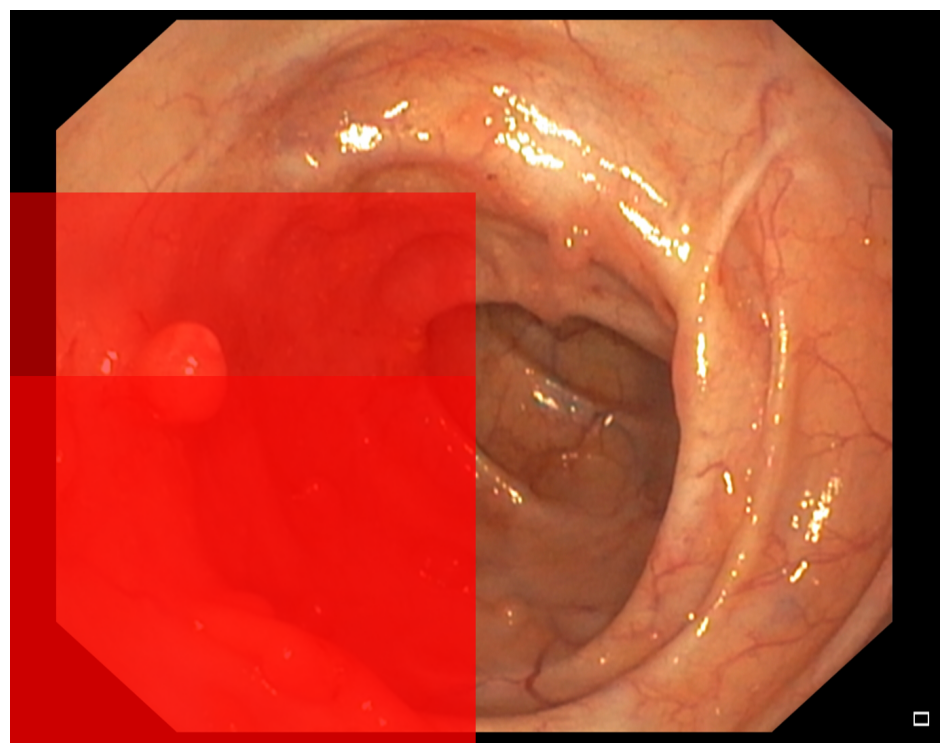

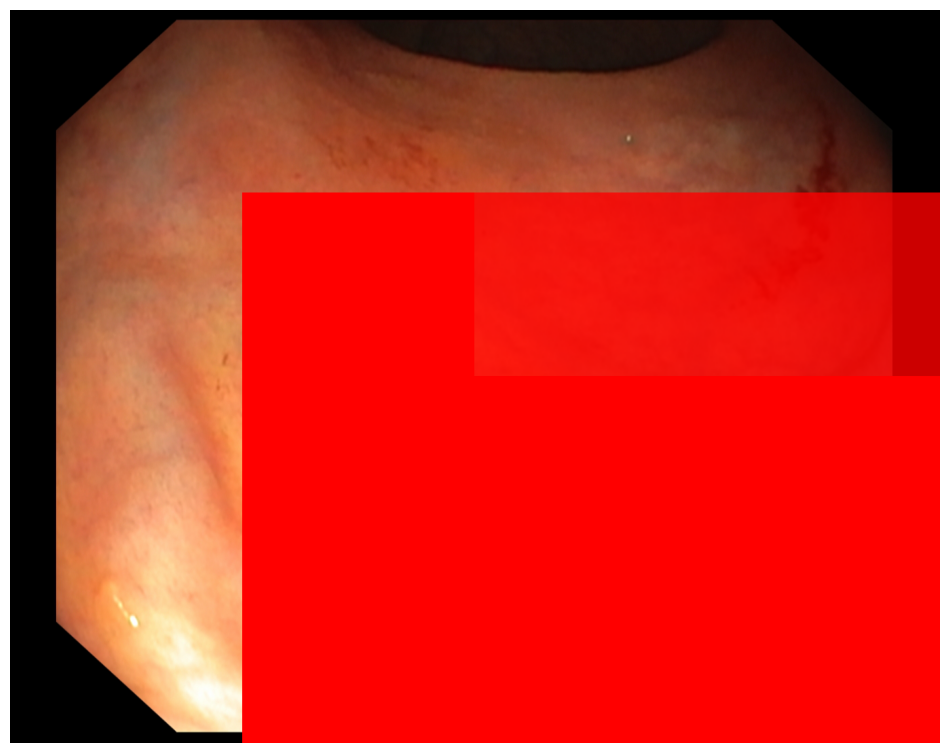

Heatmaps have been successfully saved!


In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw

def create_heatmap_overlay(paths_dic, df,desired_N_of_runs, figure_name=""):
    # Load the original image for each unique original_filename
    grouped = df.groupby('original_filename')

    for original_filename, group in grouped:
        # Load the original image based on the provided path
        original_image_path = os.path.join(paths_dic["directory_of_images"], original_filename)
        original_image = Image.open(original_image_path).convert('RGBA')  # Ensure the image is RGBA

        # Create a blank transparent overlay (same size as the original image)
        overlay = Image.new('RGBA', original_image.size, (255, 255, 255, 0))  # Fully transparent overlay

        # Draw importance tiles on the overlay
        draw = ImageDraw.Draw(overlay)

        # Process each tile in the current group (filtered by coordinates presence)
        for _, row in group.iterrows():
            x1, y1 = int(row['image_X1coordinate']), int(row['image_Y1coordinate'])
            x2, y2 = int(row['image_X2coordinate']), int(row['image_Y2coordinate'])
            importance = row['mask_importance']  # Retrieve the mask importance score

            normalized_importance = importance /  desired_N_of_runs
            if importance>0:
                # Draw a semi-transparent red rectangle on the overlay
                draw.rectangle([x1, y1, x2, y2], fill=(255, 0, 0, int(normalized_importance * 255)))  # Transparency based on importance

        # Step 7: Composite the heatmap overlay with the original image
        result = Image.alpha_composite(original_image, overlay)

        # Convert back to RGB for saving and display
        result = result.convert('RGB')

        # Step 8: Save the resulting heatmap overlay as a PNG
        output_filename_png = f"{original_filename}_{figure_name}.png"
        output_path_png = os.path.join(paths_dic["directory_of_images"], output_filename_png)
        output_filename_pdf=f"{original_filename}_{figure_name}.png"
        output_path_pdf = os.path.join(paths_dic["directory_of_images"], output_filename_pdf)
        result.save(output_path_png)
        result.save(output_path_pdf)

        # Optional: Display the result
        plt.figure(figsize=(12, 10))
        plt.imshow(result)
        plt.axis('off')
        plt.show()

    print("Heatmaps have been successfully saved!")


# Assume df is the dataframe you have with the necessary columns
df = pd.read_excel(paths_dic["mask_importance"])
figure_name="XAI-lense-heatmap"
create_heatmap_overlay(paths_dic, df, desired_N_of_runs=desired_N_of_runs,figure_name=figure_name)

## XAI-lense ConNorm consistency normalized heatmap

### Find answer counts

In [39]:
import pandas as pd
from collections import defaultdict

def find_answer_counts(paths_dic):
    # Step 1: Load the Excel file
    answered_excel_path = paths_dic["answered_excel_path"]
    df = pd.read_excel(answered_excel_path)

    # Step 2: Filter rows where "image_idx" is NaN
    df_filtered = df[df['image_idx'].isna()]

    # Step 3: Get unique values in "original_filename"
    unique_filenames = df_filtered['original_filename'].unique()

    # Step 4: Create a dictionary to store the counts of each answer for each filename
    answer_counts_dict = {}

    for filename in unique_filenames:
        # Step 5: Filter rows corresponding to this "original_filename"
        subset = df_filtered[df_filtered['original_filename'] == filename]

        # Step 6: Get the count of each unique answer in "answer_clean"
        answer_counts = subset['answer_clean'].value_counts().to_dict()

        # Step 7: Store the dictionary of answer counts in the main dictionary
        answer_counts_dict[filename] = answer_counts

    # Return the dictionary with answer counts
    return answer_counts_dict


# Example usage
answer_counts = find_answer_counts(paths_dic)
print(answer_counts)


{'336271.jpg': {'Polyp visible': 5}, '343837.jpg': {'Polyp visible': 5}}


### calculate mask importance with consistency normalization

In [40]:
import pandas as pd
from collections import defaultdict

def calculate_mask_importance_wConNorm(paths_dic, answer_counts):
    # Step 1: Load the Excel file
    answered_excel_path = paths_dic["answered_excel_path"]
    df = pd.read_excel(answered_excel_path)

    # Step 2: Filter rows where "image_idx" is not NaN (valid image_idx)
    df_valid = df[df['image_idx'].notna()]

    # Step 3: Get unique image paths
    unique_image_paths = df_valid['image_path'].unique()

    # Step 4: Initialize a dictionary to hold mask importance scores
    mask_importance_dict = defaultdict(float)

    # Step 5: Process each unique image_path
    for image_path in unique_image_paths:
        # Filter rows for this specific image_path
        subset = df_valid[df_valid['image_path'] == image_path]
        
        # Initialize a counter for the mask importance for this image_path
        mask_importance_score = 0

        # Step 6: Process each row in the subset
        for _, row in subset.iterrows():
            original_filename = row['original_filename']
            answer_clean = row['answer_clean']
            
            # Get the answer counts for the original filename
            if original_filename in answer_counts:
                # Get the total number of answers for this file
                total_answers = sum(answer_counts[original_filename].values())
                
                # Check if the answer is in the answer_counts dictionary
                if answer_clean in answer_counts[original_filename]:
                    # Calculate the score: 1 - (answer count / total answers)
                    answer_count = answer_counts[original_filename][answer_clean]
                    score = 1 - (answer_count / total_answers)
                else:
                    # If the answer is not in the dictionary, add 1
                    score = 1
            else:
                # If there are no answer counts for the filename, add 1
                score = 1

            # Add the score to the mask importance score for the current image_path
            mask_importance_score += score

        # Store the mask importance score for this image_path
        mask_importance_dict[image_path] = mask_importance_score

    # Step 7: Create a new DataFrame to store the result
    mask_importance_df = df_valid.drop_duplicates(subset=['image_path']).copy()

    # Step 8: Add the "mask_importance" column based on the computed scores
    mask_importance_df['mask_importance'] = mask_importance_df['image_path'].map(mask_importance_dict)

    # Step 9: Remove unnecessary columns (like run_N if you don't want them)
    if 'run_N' in mask_importance_df.columns:
        mask_importance_df = mask_importance_df.drop(columns=['run_N'])

    # Step 10: Save the resulting DataFrame as an Excel file
    output_path = paths_dic["mask_importance_wConNorm"]
    mask_importance_df.to_excel(output_path, index=False)

    return mask_importance_df


# Example usage
mask_importance_df = calculate_mask_importance_wConNorm(paths_dic, answer_counts)


### create ConNorm heatmap

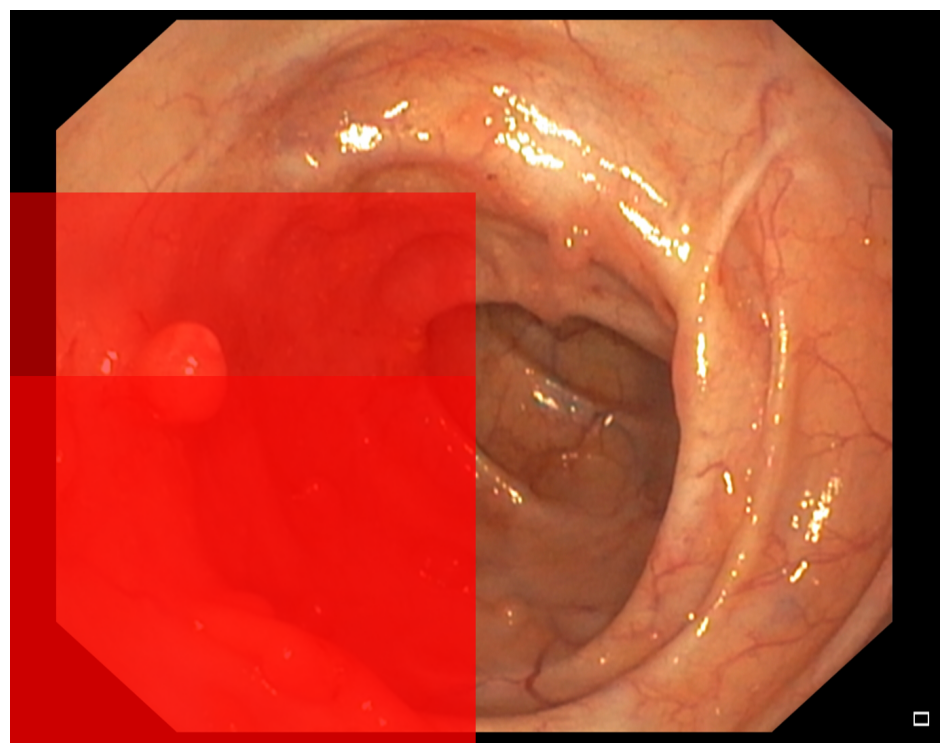

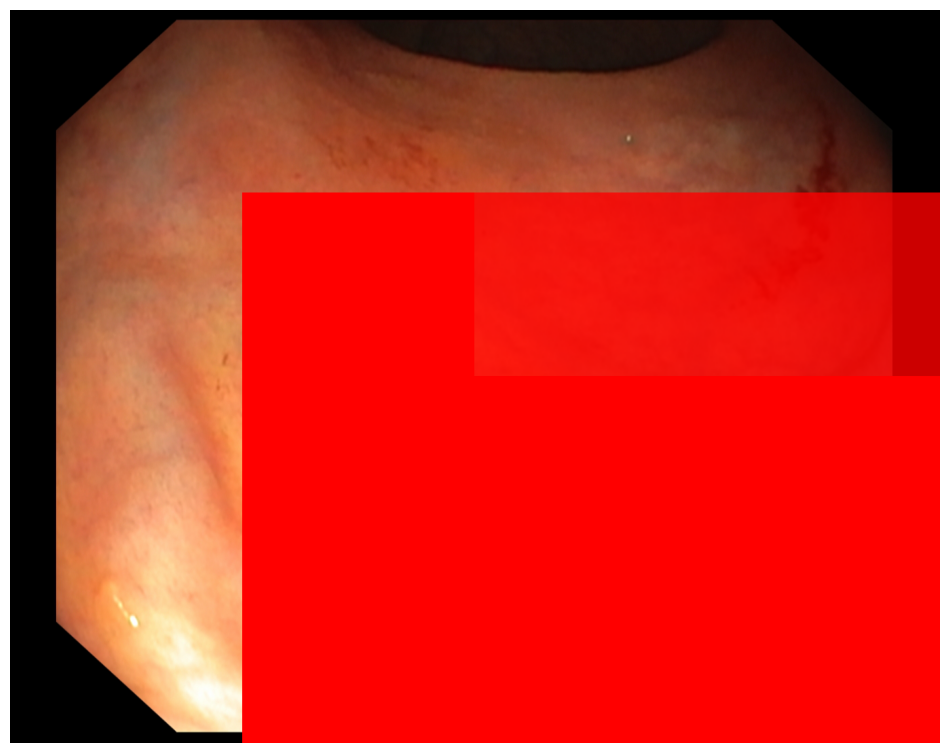

Heatmaps have been successfully saved!


In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw


# Assume df is the dataframe you have with the necessary columns
df = pd.read_excel(paths_dic["mask_importance"])


# Assume df is the dataframe you have with the necessary columns
df = pd.read_excel(paths_dic["mask_importance_wConNorm"])

figure_name="XAI-lense-ConNorm-heatmap"
create_heatmap_overlay(paths_dic, df, desired_N_of_runs=desired_N_of_runs,figure_name=figure_name)

## Prepare Image for paper

In [44]:
figures = [
    {
    "original_image":r"C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test\343837.jpg",
    "XAI_lense": r"C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test\343837.jpg_XAI-lense-heatmap.png",
    "XAI_lense_ConsistencyNormalized":r"C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test\343837.jpg_XAI-lense-ConNorm-heatmap.png" },
 {
    "original_image":r"C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test\336271.jpg",
    "XAI_lense": r"C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test\336271.jpg_XAI-lense-heatmap.png",
    "XAI_lense_ConsistencyNormalized": r"C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test\336271.jpg_XAI-lense-ConNorm-heatmap.png"},
 ]

In [45]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# Set default font and figure aesthetics for scientific standards
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['axes.linewidth'] = 1.5
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.titlesize'] = 18

def create_figure_for_images(figures):
    for figure_dict in figures:
        # Step 1: Load the images
        original_image = mpimg.imread(figure_dict["original_image"])
        xai_lense = mpimg.imread(figure_dict["XAI_lense"])
        xai_lense_connorm = mpimg.imread(figure_dict["XAI_lense_ConsistencyNormalized"])

        # Step 2: Create a figure with 1 row and 3 columns
        fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

        # Step 3: Display each image in its respective column with a minimal border
        images = [original_image, xai_lense, xai_lense_connorm]
        titles = ['Original image', 'XAI-lense', 'XAI-lense with ConNorm']
        
        for ax, img, title in zip(axes, images, titles):
            ax.imshow(img)
            ax.set_title(title, fontsize=16, weight='bold')
            ax.axis('off')
            # Add a thin border to the image
            for spine in ax.spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1.5)

        # Step 4: Get the original image directory and filename (without extension)
        original_image_path = figure_dict["original_image"]
        directory, filename_with_extension = os.path.split(original_image_path)
        filename_without_extension, _ = os.path.splitext(filename_with_extension)

        # Step 5: Save the figure in the same directory with the new name
        output_filename = f"{filename_without_extension}_FIGURE.png"
        output_path = os.path.join(directory, output_filename)
        plt.savefig(output_path, dpi=300, bbox_inches='tight')  # Save at 300 DPI for publication quality
        plt.close(fig)  # Close the figure after saving to avoid display issues

        print(f"Figure saved at: {output_path}")

# Example usage
create_figure_for_images(figures)


Figure saved at: C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test\343837_FIGURE.png
Figure saved at: C:\Users\LEGION\Documents\GIT\CMLvsLLM_onPolypImage\DO_NOT_PUBLISH\test\336271_FIGURE.png
